<a href="https://colab.research.google.com/github/joaopamaral/tcc_puc_cdbd/blob/master/Treinanco_Modelo_Reducing_Commercial_Aviation_Fatalities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Treinando Modelo - Reduzindo Fatalidades na Aviação Comercial

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

IN_COLAB = 'google.colab' in sys.modules

%matplotlib inline
plt.style.use('ggplot')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Montando google drive caso esteja executando no google colab
if IN_COLAB:
    from google.colab import drive
    drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
gdrive_kaggle_dir = '/gdrive/My Drive/Kaggle'
competition_name = 'reducing-commercial-aviation-fatalities'
api_gdrive_credential_location = f'{gdrive_kaggle_dir}/kaggle.json'
data_gdrive_dir = f'{gdrive_kaggle_dir}/{competition_name}'
tcc_dir = '/gdrive/My Drive/Pos Graduação/TCC'
mlflow_dir = f'{tcc_dir}/mlruns'
h20_models = f'{tcc_dir}/automl'
mlflow_models_path = f'{tcc_dir}/models'

## Carregando os dados

In [0]:
if IN_COLAB and not os.path.exists(competition_name):
    !cp -r '{data_gdrive_dir}' .

In [0]:
eeg_columns = ['eeg_fp1', 'eeg_f7', 'eeg_f8', 'eeg_t4', 'eeg_t6', 
               'eeg_t5', 'eeg_t3', 'eeg_fp2', 'eeg_o1', 'eeg_p3', 
               'eeg_pz', 'eeg_f3', 'eeg_fz', 'eeg_f4',	'eeg_c4', 
               'eeg_p4', 'eeg_poz', 'eeg_c3', 'eeg_cz', 'eeg_o2']

numeric_features = [*eeg_columns, 'ecg', 'r', 'gsr']
categorical_features = ['event']

In [0]:
train_df = pd.read_parquet(f'{competition_name}/train_balanced.parquet')

In [9]:
train_df.head()

,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,eeg_t3,eeg_fp2,eeg_o1,eeg_p3,eeg_pz,eeg_f3,eeg_fz,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr,event
0,-0.792237,0.831934,-9.429030,-4.17883,-1.58939,5.67909,1.763630,-2.098780,2.96651,1.44328,-3.94931,-2.22939,-4.573080,-8.084340,-8.46484,-4.68844,-4.750770,-2.04203,-4.60896,1.837780,9322.370117,815.594971,0.000000,A
1,5.937200,5.026230,-0.933735,-1.19951,4.79854,-1.96581,1.134890,4.274110,2.21295,4.60106,1.61440,5.25442,4.693770,2.867810,2.75299,8.24299,0.721092,3.08044,4.83091,3.794880,5931.060059,830.568970,1453.670044,A
2,-1.162280,0.260127,-5.989480,-3.46853,-3.87440,3.96828,0.728967,-4.655380,1.64105,-1.29032,-5.34865,-1.59114,-0.350429,-1.959580,-1.04339,-3.01729,-2.019750,-2.43368,-2.89067,-0.602369,9320.519531,815.533997,0.000000,A
3,-10.467600,-8.344960,-4.106620,-3.58671,-5.99199,-6.09401,-8.098010,-13.164800,-8.42648,-8.25574,-8.85742,-8.31783,-10.007400,-4.956020,-6.94528,-10.07500,-9.700760,-6.47439,-5.58930,-10.150300,9293.780273,816.421997,0.000000,A
4,-15.538500,-4.782070,-25.117800,-14.71600,-14.40480,-5.53229,-0.526621,-34.102798,-7.38440,-3.33520,-7.56394,-11.75630,-15.780400,-25.708401,-13.23830,-13.04150,-5.686500,-2.66797,-3.96213,-9.862170,8765.589844,814.518982,0.000000,A


In [0]:
features = numeric_features
target = 'event'

## Separando os dados de Treinamento/Validação e Testes

In [0]:
balanced_X_train, balanced_X_test, balanced_y_train, balanced_y_test = train_test_split(train_df[features], train_df[target], test_size=0.20, random_state=42)

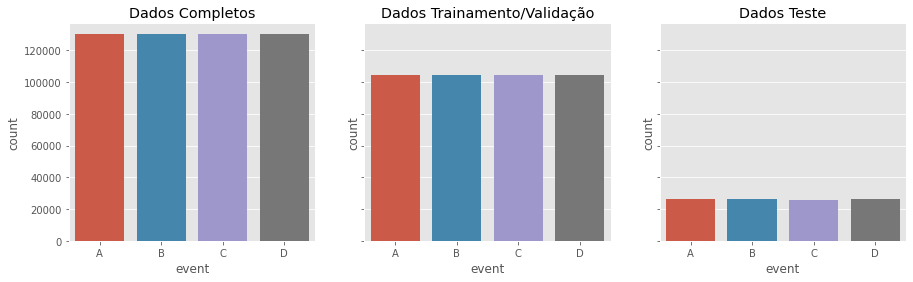

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

order = ['A', 'B', 'C', 'D']
sns.countplot(train_df[target], order=order, ax=ax[0]).set_title('Dados Completos');
sns.countplot(balanced_y_train, order=order, ax=ax[1]).set_title('Dados Trainamento/Validação');
sns.countplot(balanced_y_test, order=order, ax=ax[2]).set_title('Dados Teste');

In [0]:
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import OneHotEncoder, StandardScaler

# numeric_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='median')),
#     ('scaler', StandardScaler())])
# categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder())])

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, numeric_features),
#         # ('cat', categorical_transformer, categorical_features)
#         ])

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb

pipe = Pipeline([('classifier', RandomForestClassifier())])

search_space = [{'classifier': [LogisticRegression()]},
                {'classifier': [DecisionTreeClassifier()]},
                {'classifier': [RandomForestClassifier()],
                 'classifier__n_estimators': [100, 200, 500]},
                {'classifier': [lgb.LGBMClassifier()],
                 'classifier__n_estimators': [100, 200, 500]}]

grid_clf = GridSearchCV(pipe, search_space, cv=3, verbose=10, n_jobs=-1)
best_model = grid_clf.fit(balanced_X_train, balanced_y_train)

pd.DataFrame(best_model.cv_results_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   42.3s
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 21.9min
[Parallel(n_jobs=-1)]: Done  20 out of  24 | elapsed: 29.1min remaining:  5.8min
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 41.7min finished


In [0]:
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, classification_report, log_loss, f1_score, accuracy_score
!pip install -q -U mlflow
import mlflow
import mlflow.sklearn

if IN_COLAB:
    mlflow.set_tracking_uri(f'{mlflow_dir}')

def show_metrics(model, X_test, y_test, run_name, experiment_name='TCC', sklearn_model=True):
    mlflow.set_experiment(experiment_name)

    if sklearn_model:
        fig, ax = plt.subplots(1, 2, figsize=(10, 4))

        plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues, ax=ax[0])
        ax[0].set_title('Confusion matrix, without normalization')

        plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues, normalize='true', ax=ax[1])
        ax[1].set_title('Normalized confusion matrix')

        plt.tight_layout()
        plt.show()

        y_predict = model.predict(X_test)
        y_predict_prob = model.predict_proba(X_test)
    else:
        prediction = model.predict(h2o.H2OFrame(X_test)).as_data_frame()
        y_predict = prediction['predict']
        y_predict_prob = prediction.drop('predict', axis=1)
    score = log_loss(y_test, y_predict_prob)

    with mlflow.start_run(run_name=run_name):
        if sklearn_model:
            mlflow.log_param("model_description", str(model))
        mlflow.log_metric("f1_score", f1_score(y_test, y_predict, average='macro'))
        mlflow.log_metric("log_loss", score)
        mlflow.log_metric("accuracy", accuracy_score(y_test, y_predict))
        # mlflow.sklearn.log_model(model, "model")
        # mlflow.sklearn.save_model(model, mlflow_models_path)

    display(pd.DataFrame(classification_report(y_test, y_predict, output_dict=True)).T)
    print(f'Log loss: {score}')

     |████████████████████████████████| 16.0MB 1.4MB/s 
     |████████████████████████████████| 460kB 53.7MB/s 
     |████████████████████████████████| 153kB 51.1MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
     |████████████████████████████████| 6.0MB 51.0MB/s 
     |████████████████████████████████| 81kB 10.4MB/s 
     |████████████████████████████████| 1.1MB 49.4MB/s 
     |████████████████████████████████| 92kB 11.0MB/s 
     |████████████████████████████████| 71kB 8.7MB/s 
     |████████████████████████████████| 204kB 52.5MB/s 
     |████████████████████████████████| 81kB 10.7MB/s 


/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


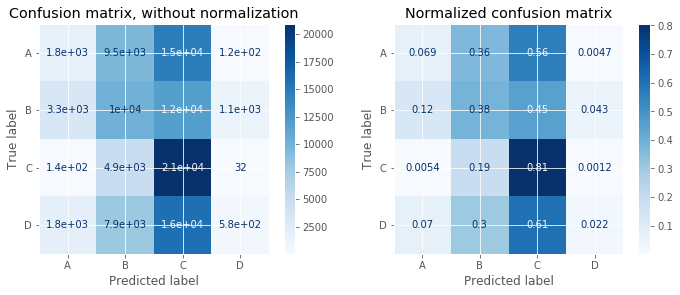

,precision,recall,f1-score,support
A,0.254882,0.068529,0.108017,26091.000000
B,0.311894,0.384156,0.344274,26307.000000
C,0.331023,0.805583,0.469233,25970.000000
D,0.310215,0.022099,0.041258,26110.000000
accuracy,0.319608,0.319608,0.319608,0.319608
macro avg,0.302004,0.320092,0.240696,104478.000000
weighted avg,0.301992,0.319608,0.240609,104478.000000


Log loss: 1.3745487622136896


In [0]:
from sklearn.linear_model import LogisticRegression

LR_clf = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', LogisticRegression(n_jobs=-1))])

LR_clf.fit(balanced_X_train, balanced_y_train)

show_metrics(LR_clf, balanced_X_test, balanced_y_test, 'LogisticRegression')

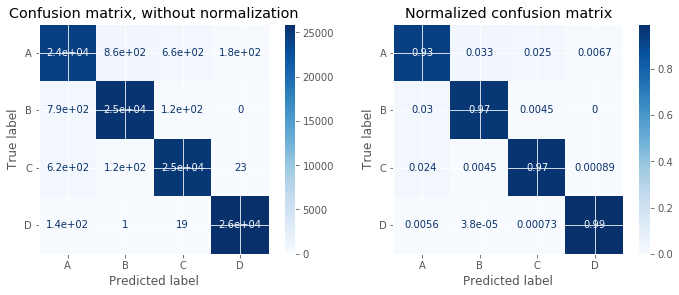

,precision,recall,f1-score,support
A,0.940145,0.934920,0.937525,26091.000000
B,0.962998,0.965560,0.964278,26307.000000
C,0.969207,0.970774,0.969990,25970.000000
D,0.992426,0.993681,0.993053,26110.000000
accuracy,0.966232,0.966232,0.966232,0.966232
macro avg,0.966194,0.966234,0.966211,104478.000000
weighted avg,0.966189,0.966232,0.966208,104478.000000


Log loss: 1.1663010693279459


In [0]:
from sklearn.tree import DecisionTreeClassifier

DT_clf = DecisionTreeClassifier()
DT_clf.fit(balanced_X_train, balanced_y_train)

show_metrics(DT_clf, balanced_X_test, balanced_y_test, 'DecisionTreeClassifier')

In [0]:
from sklearn.ensemble import RandomForestClassifier

RF_clf = RandomForestClassifier(n_jobs=-1)
RF_clf.fit(balanced_X_train, balanced_y_train)

show_metrics(RF_clf, balanced_X_test, balanced_y_test)

TypeError: ignored

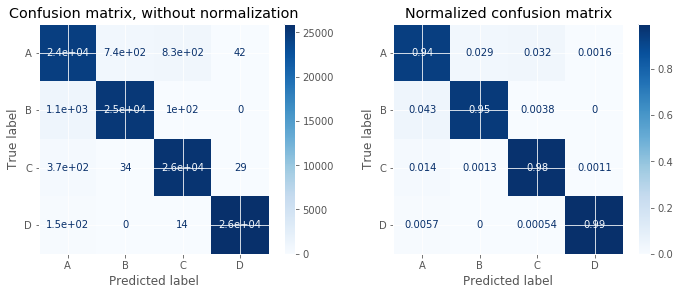

,precision,recall,f1-score,support
A,0.937012,0.937910,0.937460,26091.000000
B,0.969869,0.953168,0.961446,26307.000000
C,0.964212,0.983481,0.973751,25970.000000
D,0.997271,0.993795,0.995530,26110.000000
accuracy,0.967046,0.967046,0.967046,0.967046
macro avg,0.967091,0.967089,0.967047,104478.000000
weighted avg,0.967106,0.967046,0.967033,104478.000000


In [0]:
import lightgbm as lgb

lgbm_clf = lgb.LGBMClassifier(n_estimators=500)
lgbm_clf.fit(balanced_X_train, balanced_y_train, eval_metric='multi_error')

show_metrics(lgbm_clf, balanced_X_test, balanced_y_test)

In [0]:
lgbm_clf.fit(balanced_X, balanced_y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=500, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Training until validation scores don't improve for 50 rounds.
[100]	valid_0's multi_error: 0.0622236
[200]	valid_0's multi_error: 0.0486418
[300]	valid_0's multi_error: 0.041291
[400]	valid_0's multi_error: 0.0360076
[500]	valid_0's multi_error: 0.0329543
[600]	valid_0's multi_error: 0.0304753
[700]	valid_0's multi_error: 0.0281016
[800]	valid_0's multi_error: 0.026417
[900]	valid_0's multi_error: 0.0250675
[1000]	valid_0's multi_error: 0.0237275
Did not meet early stopping. Best iteration is:
[1000]	valid_0's multi_error: 0.0237275


ValueError: ignored

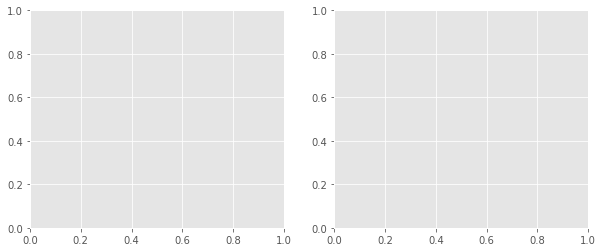

In [0]:
# import lightgbm as lgb

# events = {'A': 0,'B': 1,'C': 2, 'D': 3}
# params = {"objective" : "multiclass", "num_class": 4,'num_leaves': 31, 'metric': 'multi_error'}
# lg_train = lgb.Dataset(balanced_X_train, label=balanced_y_train.map(events))
# lg_test = lgb.Dataset(balanced_X_test, label=balanced_y_test.map(events))
# lgb_clf = lgb.train(params, lg_train, num_boost_round=1000, valid_sets=lg_test, early_stopping_rounds=50, verbose_eval=100)

# show_metrics(lgb_clf, balanced_X_test, balanced_y_test)

In [0]:
RF_clf.fit(balanced_X, balanced_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [0]:
def submit_result_kaggle(model):
    events = ['A','B','C', 'D']
    predict_results = []
    for test_chunk in tqdm(pd.read_csv(f'{competition_name}/test.csv.zip', usecols=features, dtype={feature: np.float16 for feature in numeric_features}, nrows=100000, chunksize=1000)):
        predict_results.append(model.predict(test_df))
        # predict_results.append(pd.get_dummies(pd.Categorical(model.predict(test_df), categories=events)).rename(columns=str).reset_index().rename(columns={'index': 'id'}))
    return pd.concat(predict_results)

submit_result_kaggle(RF_clf)

In [0]:
test_df = pd.read_csv(f'{competition_name}/test.csv.zip', usecols=features, dtype={feature: np.float16 for feature in numeric_features})

In [0]:
events = ['A','B','C', 'D']

pd.get_dummies(pd.Categorical(lgbm_clf.predict(test_df), categories=events)).rename(columns=str).reset_index().rename(columns={'index': 'id'}).to_csv('test_result.csv', index=False)

In [0]:
# get_kaggle_json()
!kaggle competitions submit -c reducing-commercial-aviation-fatalities -f test_result.csv -m "Submission with lgbm_clf"

100% 281M/281M [00:05<00:00, 56.9MB/s]
Successfully submitted to Reducing Commercial Aviation Fatalities

In [0]:
# from sklearn.ensemble import GradientBoostingClassifier

# GB_clf = GradientBoostingClassifier()
# GB_clf.fit(balanced_X_train, balanced_y_train)

# show_metrics(GB_clf, balanced_X_test, balanced_y_test)

In [0]:
if IN_COLAB:
    !pip install -q h2o

import h2o
from h2o.automl import H2OAutoML, get_leaderboard

h2o.init()

     |████████████████████████████████| 126.2MB 30kB/s 
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.6" 2020-01-14; OpenJDK Runtime Environment (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1); OpenJDK 64-Bit Server VM (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpolicuifo
  JVM stdout: /tmp/tmpolicuifo/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpolicuifo/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.3
H2O cluster version age:,1 month and 2 days
H2O cluster name:,H2O_from_python_unknownUser_bfawjv
H2O cluster total nodes:,1
H2O cluster free memory:,6.188 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [0]:
# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, seed=10, max_runtime_secs=6000, max_runtime_secs_per_model=600)
aml.train(x=features, y=target, training_frame=h2o.H2OFrame(pd.concat([balanced_X_train, balanced_y_train], axis=1)))

Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


In [0]:
lb = get_leaderboard(aml, extra_columns='ALL')
lb.head(rows=lb.nrows)

model_id,mean_per_class_error,logloss,rmse,mse,training_time_ms,predict_time_per_row_ms
XGBoost_2_AutoML_20200308_174249,0.0356795,0.581572,0.442178,0.195521,113801,0.005132
StackedEnsemble_AllModels_AutoML_20200308_174249,0.0371962,0.102603,0.171436,0.0293903,419530,0.192179
StackedEnsemble_BestOfFamily_AutoML_20200308_174249,0.0384154,0.107007,0.175497,0.0307991,197257,0.054111
GBM_5_AutoML_20200308_174249,0.0433286,0.190187,0.219816,0.0483191,73941,0.018438
GBM_4_AutoML_20200308_174249,0.0462935,0.159508,0.207865,0.0432079,73818,0.024457
GBM_3_AutoML_20200308_174249,0.0558804,0.17954,0.225143,0.0506893,74265,0.028178
GBM_2_AutoML_20200308_174249,0.064186,0.198391,0.238525,0.056894,74201,0.031844
DRF_1_AutoML_20200308_174249,0.066925,0.263121,0.272183,0.0740835,65194,0.028963
XGBoost_1_AutoML_20200308_174249,0.0671811,0.320585,0.300509,0.0903055,95200,0.011954
GBM_1_AutoML_20200308_174249,0.0686357,0.215213,0.249728,0.062364,72349,0.03408


In [0]:
h2o.save_model(model=aml.leader, path=h20_models, force=True)

'/gdrive/My Drive/Pos Graduação/TCC/automl/XGBoost_2_AutoML_20200308_174249'

In [0]:
aml.leader

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_20200305_231356


Model Summary: 


,,number_of_trees
0,,15.0




ModelMetricsMultinomial: xgboost
** Reported on train data. **

MSE: 0.2218395938884507
RMSE: 0.47099850731021503
LogLoss: 0.6380030322783364
Mean Per-Class Error: 0.025174774305688492

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,A,B,C,D,Error,Rate
0,124632.0,2104.0,3637.0,224.0,0.045675,"5,965 / 130,597"
1,3880.0,126142.0,571.0,4.0,0.034113,"4,455 / 130,597"
2,1559.0,128.0,128809.0,101.0,0.013691,"1,788 / 130,597"
3,848.0,41.0,54.0,129654.0,0.007221,"943 / 130,597"
4,130919.0,128415.0,133071.0,129983.0,0.025175,"13,151 / 522,388"



Top-4 Hit Ratios: 


,k,hit_ratio
0,1,0.974825
1,2,0.998319
2,3,0.999870
3,4,1.000000



ModelMetricsMultinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.22908219696071616
RMSE: 0.47862532001631103
LogLoss: 0.651384465271902
Mean Per-Class Error: 0.03351340383010329

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,A,B,C,D,Error,Rate
0,122113.0,2919.0,5166.0,399.0,0.064963,"8,484 / 130,597"
1,4949.0,124872.0,770.0,6.0,0.043837,"5,725 / 130,597"
2,1709.0,204.0,128542.0,142.0,0.015735,"2,055 / 130,597"
3,1119.0,51.0,73.0,129354.0,0.009518,"1,243 / 130,597"
4,129890.0,128046.0,134551.0,129901.0,0.033513,"17,507 / 522,388"



Top-4 Hit Ratios: 


,k,hit_ratio
0,1,0.966487
1,2,0.997282
2,3,0.999853
3,4,1.000000



Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.9664866,0.0017621436,0.9666724,0.96588755,0.9662225,0.9644036,0.9692468
1,err,0.0335134,0.0017621436,0.03332759,0.034112446,0.033777446,0.035596352,0.03075318
2,err_count,3501.4,184.10677,3482.0,3564.0,3529.0,3719.0,3213.0
3,logloss,0.6513842,0.11341939,0.70659226,0.7062797,0.6750749,0.7184324,0.4505418
4,max_per_class_error,0.06496324,0.005659207,0.062136292,0.06420367,0.06248325,0.07488801,0.061104942
5,mean_per_class_accuracy,0.9664866,0.001762063,0.96667254,0.9658876,0.96622247,0.96440375,0.9692467
6,mean_per_class_error,0.033513412,0.001762063,0.03332747,0.034112398,0.033777565,0.035596278,0.03075334
7,mse,0.22908208,0.054022547,0.2554727,0.25530365,0.23984256,0.2612936,0.13349788
8,r2,0.8167345,0.043217536,0.7956219,0.7957602,0.808126,0.79096353,0.8932009
9,rmse,0.4753997,0.062019996,0.50544304,0.5052758,0.48973724,0.51116884,0.3653736



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error
0,,2020-03-05 23:34:18,8 min 13.721 sec,0.0,0.750000,1.386294,0.750000
1,,2020-03-05 23:34:55,8 min 50.007 sec,5.0,0.647052,1.043113,0.031819
2,,2020-03-05 23:35:30,9 min 25.431 sec,10.0,0.556204,0.814712,0.027970
3,,2020-03-05 23:36:06,10 min 1.315 sec,15.0,0.470999,0.638003,0.025175



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,gsr,1.570094e+06,1.000000,0.325937
1,ecg,1.350949e+06,0.860426,0.280445
2,r,1.339027e+06,0.852832,0.277970
3,eeg_fp2,7.263934e+04,0.046264,0.015079
4,eeg_fp1,5.595013e+04,0.035635,0.011615
5,eeg_f7,5.314608e+04,0.033849,0.011033
6,eeg_f3,5.286027e+04,0.033667,0.010973
7,eeg_f8,4.802113e+04,0.030585,0.009969
8,eeg_f4,4.695535e+04,0.029906,0.009748
9,eeg_fz,3.390040e+04,0.021591,0.007037



See the whole table with table.as_data_frame()


In [0]:
show_metrics(aml.leader, balanced_X_test, balanced_y_test, 'H2O Automl XGboost', sklearn_model=False)
# aml.leader.predict(h2o.H2OFrame(balanced_X_test.head())).as_data_frame().drop('predict', axis=1).idxmax(axis=1)

Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%


,precision,recall,f1-score,support
A,0.938837,0.938370,0.938603,26091.000000
B,0.975234,0.956513,0.965783,26307.000000
C,0.957670,0.982672,0.970010,25970.000000
D,0.996378,0.990272,0.993315,26110.000000
accuracy,0.966921,0.966921,0.966921,0.966921
macro avg,0.967030,0.966957,0.966928,104478.000000
weighted avg,0.967063,0.966921,0.966927,104478.000000


Log loss: 0.563553416423517


In [0]:
events = ['A','B','C', 'D']

pd.get_dummies(pd.Categorical(aml.predict(h2o.H2OFrame(test_df)).as_data_frame(), categories=events)).rename(columns=str).reset_index().rename(columns={'index': 'id'}).to_csv('test_result.csv', index=False)

In [0]:
get_kaggle_json()
!kaggle competitions submit -c reducing-commercial-aviation-fatalities -f test_result.csv -m "Submission AutoML H2o"